Now we use the KDE techniques from the previous example to load and plot some real data :) 

In [2]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import math
import mplstereonet

#load SNE
sys.path.append("../../")
from pycompass.IOTools import ccXML
from pycompass.SNE import pdf

%matplotlib inline

In [3]:
#setup matplotlib
plt.style.use(['default'])
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

Load Data
===========

In the following we load SNE data generate using the Compass plugin in CloudCompare and exported to the *hoyo_verde_alto.xml* file in the *example_data* folder.

In [70]:
data = ccXML("example_data/risco_liso_summit.xml")

Then we extract the SNEs and use them to generate a spherical KDE (stereonet), strike KDE (rose diagram) and thickness KDE.

**Warning: this step is pretty slow with larger (aka real) datasets such as this one... hence the implementation of KDEs in cython!**

In [76]:
#loop through geo-objects in file
geoObjects = data.filterByKey("GEO_OBJECT")

spherical_kdes = []
strike_kdes = []
thick_kdes = []

grid = pdf.grid(100)
_thick = np.linspace(0,15,1000)
for g in geoObjects:
    #loop through SNEs belonging to this GeoObject
    SNEs = data.filterByName("SNE_Samples",data=g)

    trend = []
    plunge = []
    thick = []
    for s in SNEs:
        #gather data from SNE points
        points = s["POINTS"]
        trend += list(np.fromstring( points["trend"], dtype=np.float, sep=','))
        plunge += list(np.fromstring( points["plunge"], dtype=np.float, sep=','))
        thick += list(np.fromstring( points["thickness"], dtype=np.float, sep=','))

    #calculate KDEs for each structure
    if len(trend) > 0:
        spherical_kdes.append( pdf.sphericalKDE(grid,np.array([trend,plunge]),2.5,degrees=True) )
        strike_kdes.append( pdf.circularKDE( np.array(trend) - 90, 2.5 ) ) #n.b. -90 converts pole trends to strikes    
        thick_kdes.append(scipy.stats.gaussian_kde(thick,bw_method=0.05)(_thick))

And plot a stereonet:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


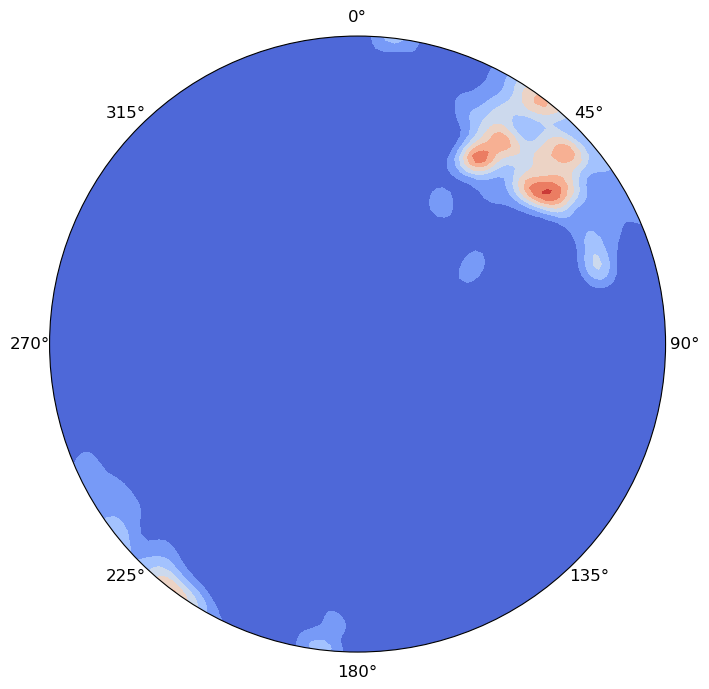

In [72]:
#stack KDEs from each structure
kde = np.sum(spherical_kdes,axis=0)

#reshape kde into a grid
res = int(np.sqrt(grid.shape[1]))
assert res == np.sqrt(grid.shape[1]), "Error plotting KDE - supplied grid must be square."
kde2D = np.reshape(kde,(res,res)).T

#build meshgrid of plotting coordinates (in lat,lon)
bound = np.pi / 2
X,Y = np.meshgrid(np.linspace(-bound,bound,res), np.linspace(-bound,bound,res)) #rectangular plot of polar data

#plot
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='stereonet')
#cs = ax1.pcolormesh(X,Y,kde2D)
cs = ax1.contourf(X,Y,kde2D,cmap="coolwarm")

fig.show()

And a rose diagram:

In [73]:
def plotRoseKDE(strikesKDE, **kwds):
    
    _theta = np.linspace(0,360,len(strikesKDE)*2)
    _dens = np.append(strikesKDE,strikesKDE)
    
    if "ax" in kwds:
        ax = kwds.get("ax")
        fig = ax.figure
    else:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, projection='polar')
        
    ax.plot( np.deg2rad(_theta),_dens, color='k')
    ax.fill( np.deg2rad(_theta),_dens, color='gray',alpha=0.25)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.get_yaxis().set_visible(False)
    return fig, ax

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


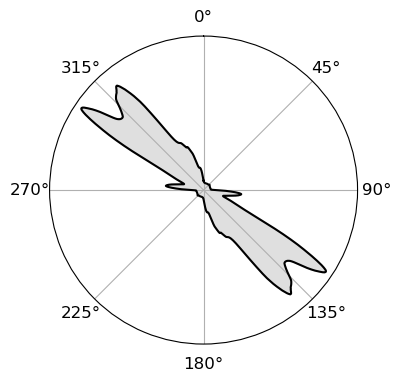

In [74]:
fig,ax = plotRoseKDE(np.sum(strike_kdes,axis=0))
fig.show()

And finally the thickness KDE:

(0, 5)

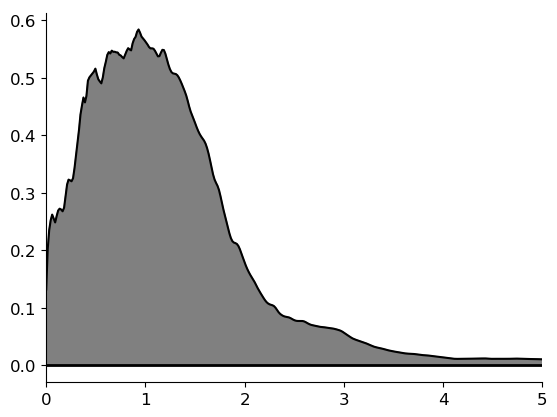

In [77]:
plt.plot(_thick,np.sum(thick_kdes,axis=0) / len(thick_kdes),color='k')
plt.fill_between( _thick ,np.sum(thick_kdes,axis=0) / len(thick_kdes),color='gray')
plt.axhline(0,color='k',lw=2)
plt.xlim(0,5)